<a href="https://colab.research.google.com/github/guevelel/COMP4449_Image_Classification/blob/main/Traffic_Signs_COMP4449.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recognizing Traffic Signs
The goal of this project is to build a model capable of determining the type of traffic sign that is displayed in an image captured under different real-life conditions and showing obstructions, poor lighting, or even the sign being far away from the camera. We provide you with labeled images already splited in three files (tran/val/test) and a predefined list of signs to recognise. 

In [1]:
#Questions:
#What are the size, and coords features in the dataset?
#
#
#use random number generator to mimic incoming image?

In [1]:
%pip install torchmetrics


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 8.0 MB/s eta 0:00:00


In [2]:
#Import libraries:
import pandas as pd
import pickle
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import tensorflow as tf 
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import roc_curve
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

In [3]:
# Download and unzip
dataroot = "dataroot/"
!mkdir dataroot 
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_2.zip
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_3.zip 

--2023-04-11 04:02:49--  https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32074743 (31M) [application/zip]
Saving to: ‘dataroot/data_1.zip’

data_1.zip          100%[===================>]  30.59M  --.-KB/s    in 0.1s    

2023-04-11 04:02:49 (227 MB/s) - ‘dataroot/data_1.zip’ saved [32074743/32074743]

--2023-04-11 04:02:49--  https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.19

In [4]:
# Unzip github files into colab folders:
with zipfile.ZipFile(dataroot+"data_1.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)
with zipfile.ZipFile(dataroot+"data_2.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)
with zipfile.ZipFile(dataroot+"data_3.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)

In [5]:
# Load sign names into a dictionary:
df = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/signnames.csv")
signnames = pd.Series(df.SignName.values,index=df.ClassId).to_dict()
#signnames
#signnames.values()

In [6]:
# Load training, validation, and testing images:
train = pickle.load( open( dataroot+"train.p", "rb" ) )
val = pickle.load( open( dataroot+"valid.p", "rb" ) )
test = pickle.load( open( dataroot+"test.p", "rb" ) )

print(train.keys())
type(train)


dict_keys(['coords', 'labels', 'features', 'sizes'])


dict

The image shows a Turn left ahead sign


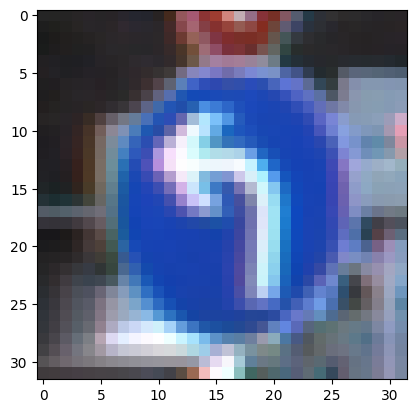

In [7]:
# Preview random image:
inx = 20123
plt.imshow(train['features'][inx])
print("The image shows a {} sign".format(signnames[train['labels'][inx]]))

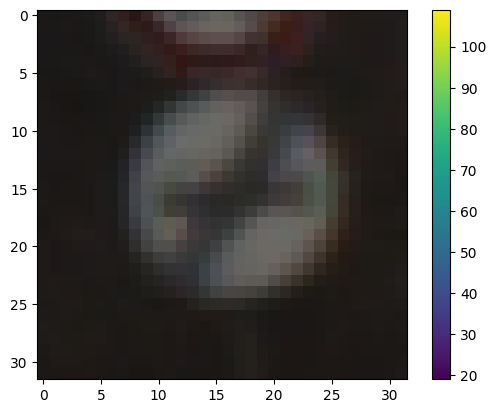

In [8]:

#https://levelup.gitconnected.com/pixels-arrays-and-images-ef3f03638fe7
#A color image is comprised of three channels: red, green, and blue.
#These channels correspond to the those in a single pixel.
#When a computer reads (or writes) an image, it takes the intensity values of each channel in a pixel 
#and stores them in corresponding cells of a 3D-array.

#https://www.tensorflow.org/tutorials/images/classification

plt.figure()
plt.imshow(train['features'][1])
plt.colorbar()
plt.grid(False)
plt.show()


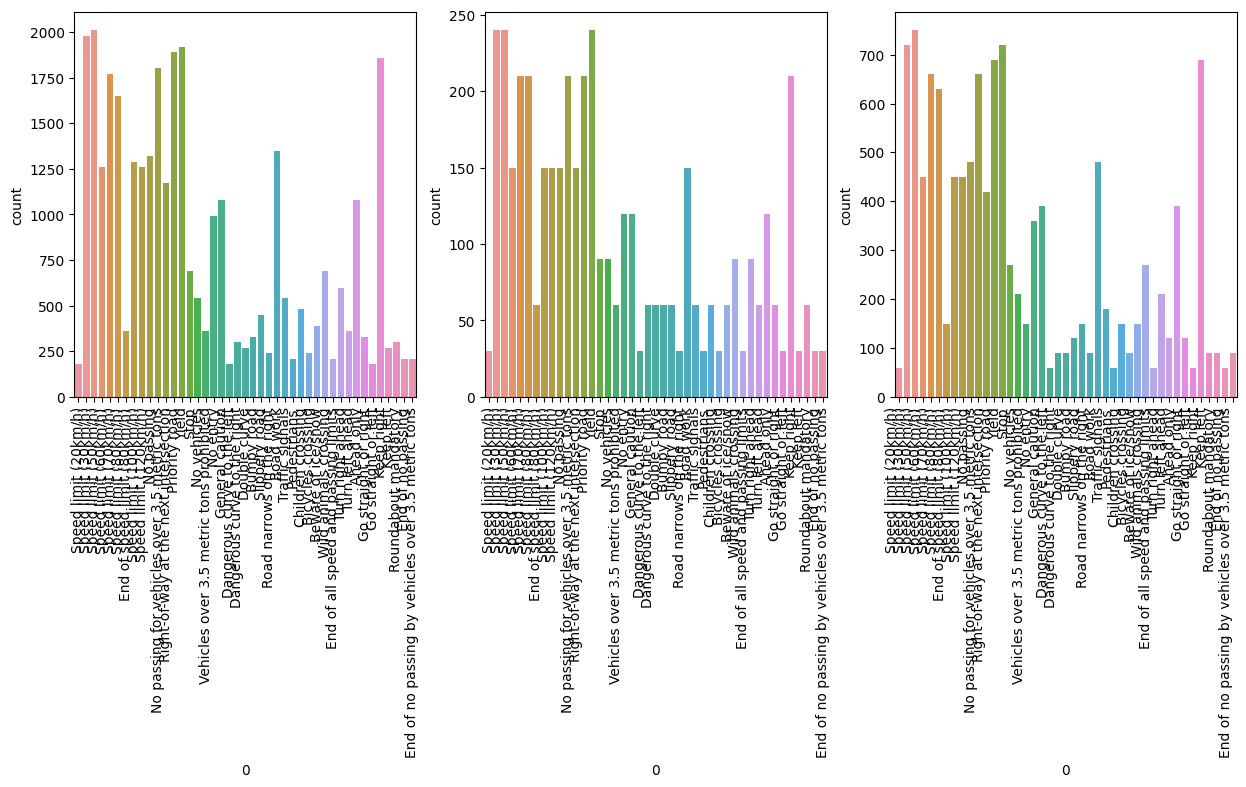

In [9]:
#Plot the distributions of the training, validation, and test data:

#Convert data to DF:
data_train = pd.DataFrame(train['labels'])
data_val = pd.DataFrame(val['labels'])
data_test = pd.DataFrame(test['labels'])

#Generate countplots:
fig, ax =plt.subplots(1,3, figsize=(15,5))
sns.countplot(data_train, x=data_train[0], ax=ax[0])
ax[0].set_xticklabels(list(signnames.values()))
for tick in ax[0].get_xticklabels():
    tick.set_rotation(90)

sns.countplot(data_val, x=data_val[0], ax=ax[1])
ax[1].set_xticklabels(list(signnames.values()))
for tick in ax[1].get_xticklabels():
    tick.set_rotation(90)

sns.countplot(data_test, x=data_test[0], ax=ax[2])
ax[2].set_xticklabels(list(signnames.values()))
plt.xticks(rotation=90, ha='right')

plt.show()

In [10]:


#Split out data into training, validation, and test sets:
X_train = train['features']
y_train = train['labels']
X_val = val['features']
y_val = val['labels']
X_test = test['features']
y_test = test['labels']

#need to normalize images to feed into NN:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Reshape and one hot encode:
y_train = tf.one_hot(y_train, 43)
y_val = tf.one_hot(y_val, 43)
y_test = tf.one_hot(y_test, 43)

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 34799
number of test examples = 12630
X_train shape: (34799, 32, 32, 3)
Y_train shape: (34799, 43)
X_val shape: (4410, 32, 32, 3)
Y_val shape: (4410, 43)
X_test shape: (12630, 32, 32, 3)
Y_test shape: (12630, 43)


Now, the shape of our data is (34799, 32, 32, 3), where 34799 represents the number of images,32*32 represents the image sizes into pixels, and the last 3 represents the RGB value(availability of coloured data).

In [11]:
#Convert data to tensors and move to GPU for faster computing
#setup device agnostoc code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

#X_train = torch.from_numpy(X_train).type(torch.float32)
#X_train = torch.Tensor(X_train)
#X_train = X_train.to(device)
#X_val = torch.from_numpy(X_val).type(torch.float32)
#X_val = torch.Tensor(X_val)
#X_val= X_val.to(device)
#X_test = torch.from_numpy(X_test).type(torch.float32)
#X_test = torch.Tensor(X_test)
#X_test = X_test.to(device)

#y_train = y_train.to(device)
#y_val = y_val.to(device)
#y_test = y_test.to(device)

#print(X_train.shape, type(X_train), X_train.device)

cuda


In [13]:
#X_train = torch.from_numpy(X_train)
#X_train = X_train.to(device)
#print(X_train.shape, type(X_train), X_train.device)

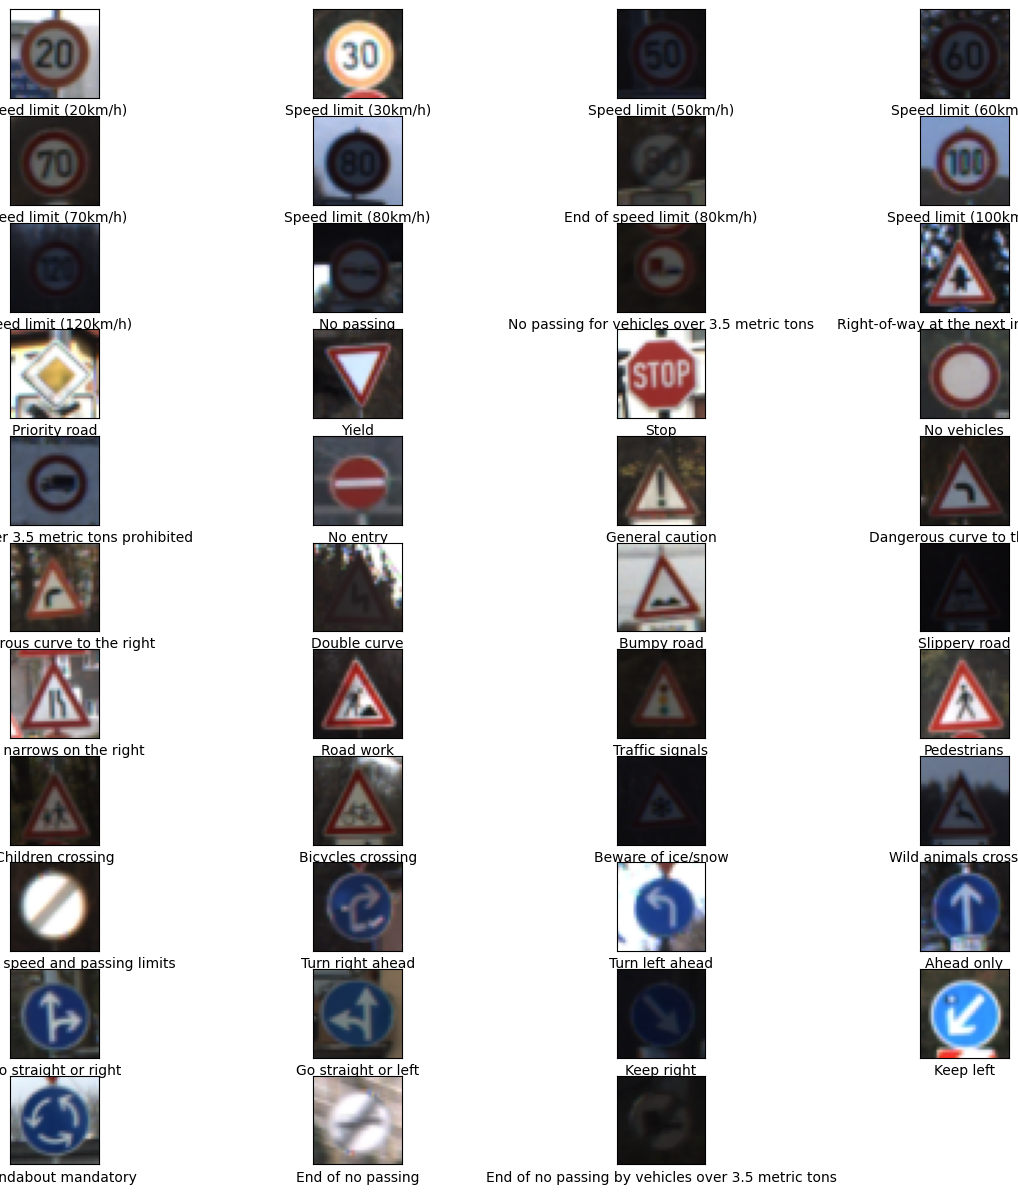

In [12]:
#Visualize all of the different road signs:

plt.figure(figsize=(15,15))

for i in range(43):
  plt.subplot(11,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  titles = np.where(train['labels']==i)
  index = titles[0][50]
  plt.imshow(train['features'][index], cmap=plt.cm.binary)
  plt.xlabel(signnames[train['labels'][index]])


plt.show()


In [15]:
#Build Neural Network Model: 
tf.random.set_seed(42)
np.random.seed(42)

#Using an existing LeNet-5 Neural Network for image classification as baseline model
#LeNet-5 
model = Sequential()
model.add(Conv2D(filters=5, kernel_size=(5,5), activation='relu', padding='valid', input_shape=X_train.shape[1:]))
model.add(AveragePooling2D(pool_size=(2,2),strides=2,padding='valid',data_format=None,)) #is this right?
model.add(Conv2D(filters=5, kernel_size=(5,5), activation='relu', padding='valid'))
model.add(AveragePooling2D(pool_size=(2,2),strides=2,padding='valid',data_format=None,)) #is this right?
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(43, activation='softmax'))

#Compile the model:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


#Dense layers are fully connected
#Convolutional, Pooling, LSTM
#Dropout
#Flatten
#Reshape
#Pooling
#Convolutional


In [16]:
#Set number of Epochs:
eps = 12

#Fit model and track the accuracy and loss:
history = model.fit(X_train, y_train, batch_size=32, epochs=eps, validation_data=(X_val, y_val))


Epoch 1/12
1088/1088 [==============================] - 37s 31ms/step - loss: 1.4824 - accuracy: 0.5976 - val_loss: 0.8526 - val_accuracy: 0.7769
Epoch 2/12
1088/1088 [==============================] - 31s 28ms/step - loss: 0.4892 - accuracy: 0.8602 - val_loss: 0.6834 - val_accuracy: 0.8136
Epoch 3/12
1088/1088 [==============================] - 30s 27ms/step - loss: 0.3304 - accuracy: 0.9090 - val_loss: 0.6540 - val_accuracy: 0.8295
Epoch 4/12
1088/1088 [==============================] - 31s 28ms/step - loss: 0.2437 - accuracy: 0.9316 - val_loss: 0.6701 - val_accuracy: 0.8367
Epoch 5/12
1088/1088 [==============================] - 32s 29ms/step - loss: 0.1921 - accuracy: 0.9468 - val_loss: 0.5247 - val_accuracy: 0.8816
Epoch 6/12
1088/1088 [==============================] - 30s 28ms/step - loss: 0.1549 - accuracy: 0.9574 - val_loss: 0.5804 - val_accuracy: 0.8723
Epoch 7/12
1088/1088 [==============================] - 32s 30ms/step - loss: 0.1233 - accuracy: 0.9651 - val_loss: 0.6269 -

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 5)         380       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 5)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 5)         630       
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 5)          0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 125)               0         
                                                                 
 dense (Dense)               (None, 120)               1

The history.history["loss"] entry is a dictionary with as many values as epochs that the model was trained on. 

       loss  accuracy  val_loss  val_accuracy
0  1.482396  0.597632  0.852607      0.776871
1  0.489226  0.860168  0.683390      0.813605
2  0.330363  0.909049  0.654031      0.829478
3  0.243679  0.931607  0.670112      0.836735
4  0.192120  0.946751  0.524699      0.881633


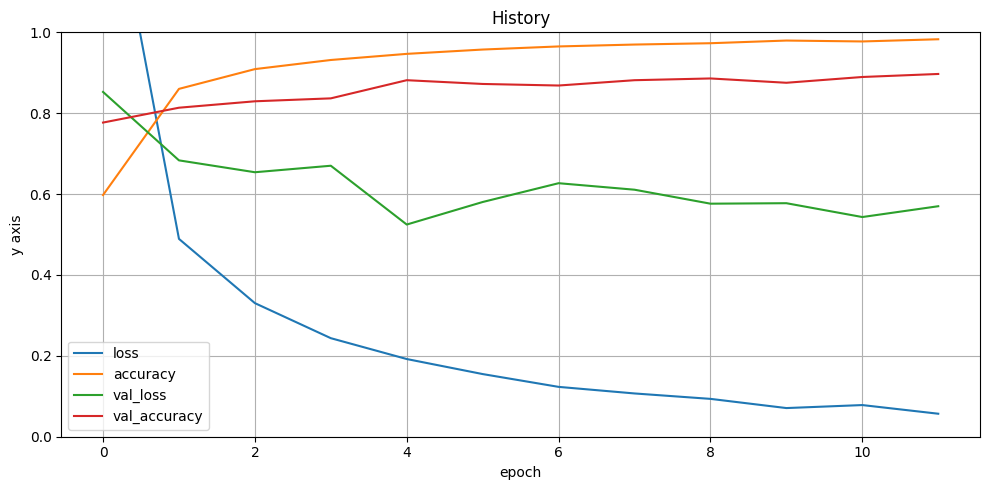

In [18]:
# Plot the train and validation accuracy and loss curves:
#df_loss_acc = pd.DataFrame(history.history)
#df_loss= df_loss_acc[['loss','val_loss']]
#df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
#df_acc= df_loss_acc[['accuracy','val_accuracy']]
#df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
#df_loss.plot(title='Model loss',figsize=(4,4)).set(xlabel='Epoch',ylabel='Loss')
#df_acc.plot(title='Model Accuracy',figsize=(4,4)).set(xlabel='Epoch',ylabel='Accuracy')


#Plot the loss and accuracy v. Epoch
df=pd.DataFrame(history.history)
print(df.head())

fig,ax=plt.subplots(figsize=(10,5))
ax.plot(df['loss'], label='loss')
ax.plot(df['accuracy'], label='accuracy')
ax.plot(df['val_loss'], label='val_loss')
ax.plot(df['val_accuracy'], label='val_accuracy')
ax.legend(loc=0)
ax.set_title('History')
ax.set_xlabel('epoch')
ax.set_ylabel('y axis')
ax.set_ylim(0,1)
ax.grid()
plt.tight_layout()
plt.show()

In [19]:
#Assess accuracy on Test set:
model.evaluate(X_test, y_test)

395/395 [==============================] - 4s 10ms/step - loss: 0.9234 - accuracy: 0.8774


[0.9234300255775452, 0.8774346709251404]

In [20]:
#Extract the model predictions on the test set (for confusion matrix building):
tf.random.set_seed(42)
np.random.seed(42)

pred = model.predict(X_test)
#pred

#Convert label matrices to index values for confustion matrix:
y_preds = []
for i in range(len(pred)):
  y_preds.append(np.argmax(pred[i]))
#y_preds

y_act = []
for i in range(len(y_test)):
  y_act.append(np.argmax(y_test[i]))
#y_act

#import torch
y_act =torch.Tensor(y_act)
y_preds = torch.Tensor(y_preds)

395/395 [==============================] - 4s 10ms/step


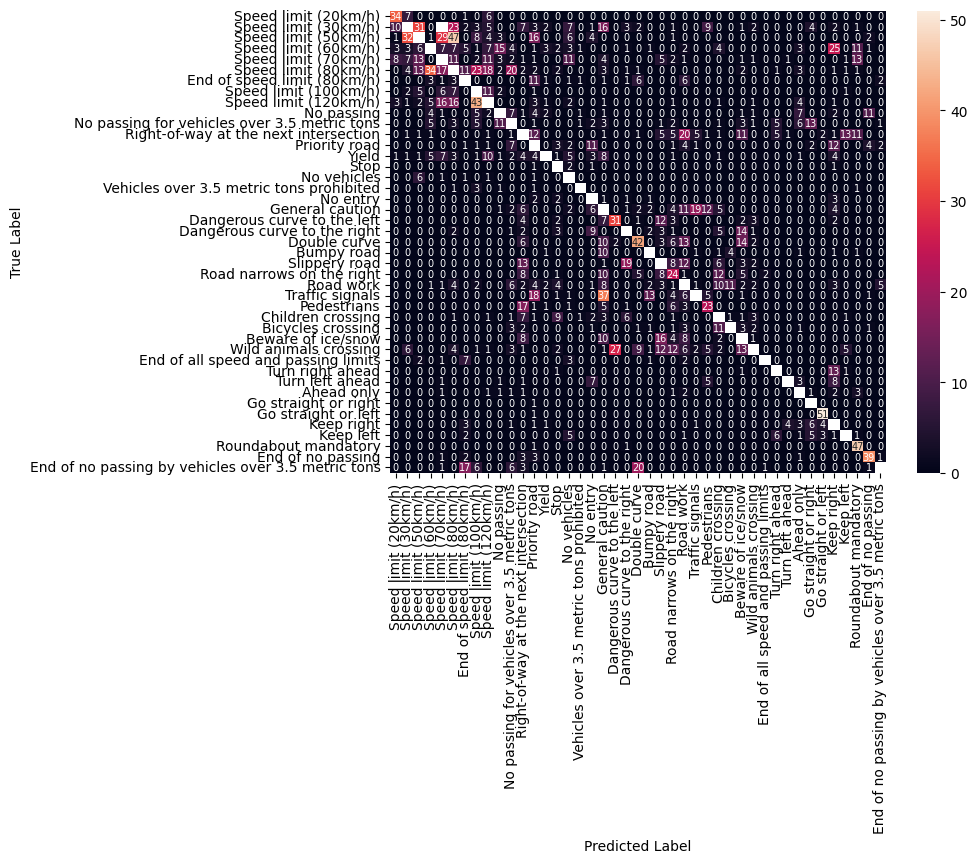

In [34]:
#Plot heatmap of classification results (masking values >50 to point out misclassifications)
fig, ax = plt.subplots(figsize=(8,6))
corr = confusion_matrix(y_preds, y_act)
names = signnames.values()
#corr/np.sum(corr), fmt='.1%'
sns.heatmap(corr, annot=True,
            xticklabels=names,yticklabels=names, fmt='d',annot_kws={"size": 7},
            mask= corr >51)#,
            #cmap="Blues")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

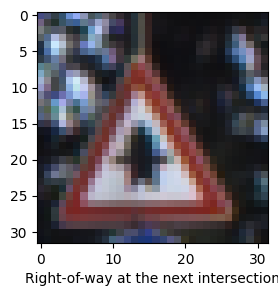

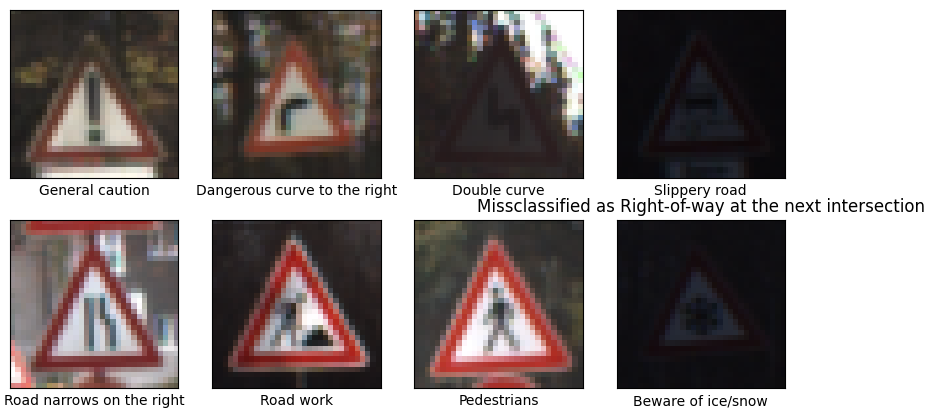

In [22]:
#Error analysis:

#Look at 'Right-of-way at the next intersection' v (general caution and dangerous curve to the left) since those were mis-classified
#more frequently than others

error_pics = [18,20,21,23,24,25, 27, 30]
actual = [11] #Right-of-way at the next intersection Index

plt.figure(figsize=(3,3))
titles = np.where(train['labels']==actual)
index = titles[0][50]
plt.imshow(train['features'][index], cmap=plt.cm.binary)
plt.xlabel(signnames[train['labels'][index]])
plt.show()

plt.figure(figsize=(10,5))
#for i in range(len(error_pics)):
count = 1
for i in error_pics:
  plt.subplot(2,4,count)
  count+=1
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  titles = np.where(train['labels']==i)
  index = titles[0][50]
  plt.imshow(train['features'][index], cmap=plt.cm.binary)
  plt.xlabel(signnames[train['labels'][index]])

plt.title("Missclassified as Right-of-way at the next intersection")
plt.show()

#signnames


In [23]:
#Data Augmentation:
#Rotating, zooming, etc. images
#this makes model more robust to new images it will attempt to classify. Not all images taken are perfect size, shape, etc. 

# set up your data generator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=45,
    #brightness_range=[.9,10.0],
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1, #slight zooming
    horizontal_flip=False, #no flipping
    vertical_flip = False)

# Fit the generator using your data
datagen.fit(X_train)

# Augment the training data images
#augmented = datagen.random_transform(X_train[0])

augmented = []
for i in range(len(X_train)):
  augmented.append(datagen.random_transform(X_train[i], seed = 42))
  augmented.append(datagen.random_transform(X_train[i], seed = 42))
  #augmented.append(datagen.flow(X_train[i]))
  #augmented.append(apply_transform(X_train[i]))

#augmented = datagen.flow(X_train)
#len(augmented)

In [24]:
len(augmented)

69598

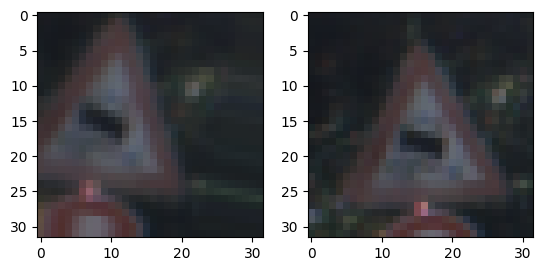

In [25]:
#Show Comparison of Images:
plt.subplot(1,2,1)
z = 4004
plt.imshow(augmented[z])
plt.subplot(1,2,2)
plt.imshow(X_train[int(z/2)])


In [26]:
#Combine rotated training images with actual training images increase training data size
X_train_enlarged = np.vstack((X_train, augmented))
print(X_train_enlarged.shape)

y_train_enlarged = np.vstack((y_train, y_train, y_train))
print(y_train_enlarged.shape)

(104397, 32, 32, 3)
(104397, 43)


In [27]:
#Retrain Model with additional data:
tf.random.set_seed(42)
np.random.seed(42)
eps = 12

#LeNet-5 
model = Sequential()
model.add(Conv2D(filters=5, kernel_size=(5,5), activation='relu', padding='valid', input_shape=X_train.shape[1:]))
model.add(AveragePooling2D(pool_size=(2,2),strides=2,padding='valid',data_format=None,)) #is this right?
model.add(Conv2D(filters=5, kernel_size=(5,5), activation='relu', padding='valid'))
model.add(AveragePooling2D(pool_size=(2,2),strides=2,padding='valid',data_format=None,)) #is this right?
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(43, activation='softmax'))

#Compile the model:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fit the model:
history2 = model.fit(X_train_enlarged, y_train_enlarged, batch_size=32, epochs=eps, validation_data=(X_val, y_val))


Epoch 1/12
3263/3263 [==============================] - 91s 27ms/step - loss: 2.0734 - accuracy: 0.4074 - val_loss: 1.1518 - val_accuracy: 0.6871
Epoch 2/12
3263/3263 [==============================] - 88s 27ms/step - loss: 1.1156 - accuracy: 0.6435 - val_loss: 0.9196 - val_accuracy: 0.7669
Epoch 3/12
3263/3263 [==============================] - 86s 26ms/step - loss: 0.8603 - accuracy: 0.7166 - val_loss: 0.9652 - val_accuracy: 0.7692
Epoch 4/12
3263/3263 [==============================] - 88s 27ms/step - loss: 0.7177 - accuracy: 0.7607 - val_loss: 0.9421 - val_accuracy: 0.7918
Epoch 5/12
3263/3263 [==============================] - 86s 26ms/step - loss: 0.6265 - accuracy: 0.7911 - val_loss: 1.0164 - val_accuracy: 0.8016
Epoch 6/12
3263/3263 [==============================] - 88s 27ms/step - loss: 0.5596 - accuracy: 0.8126 - val_loss: 0.9571 - val_accuracy: 0.8086
Epoch 7/12
3263/3263 [==============================] - 90s 28ms/step - loss: 0.5117 - accuracy: 0.8283 - val_loss: 0.9510 -

       loss  accuracy  val_loss  val_accuracy
0  2.073380  0.407445  1.151763      0.687075
1  1.115553  0.643524  0.919605      0.766893
2  0.860284  0.716572  0.965236      0.769161
3  0.717749  0.760683  0.942120      0.791837
4  0.626498  0.791134  1.016423      0.801587


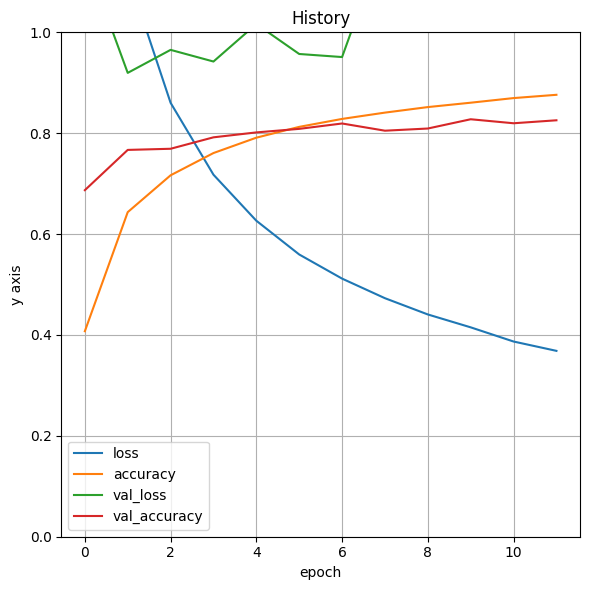

In [28]:
#Plot the loss and accuracy v. Epoch
df=pd.DataFrame(history2.history)
print(df.head())

fig,ax=plt.subplots(figsize=(6,6))
ax.plot(df['loss'], label='loss')
ax.plot(df['accuracy'], label='accuracy')
ax.plot(df['val_loss'], label='val_loss')
ax.plot(df['val_accuracy'], label='val_accuracy')
ax.legend(loc=0)
ax.set_title('History')
ax.set_xlabel('epoch')
ax.set_ylabel('y axis')
ax.set_ylim(0,1)
ax.grid()
plt.tight_layout()
plt.show()

In [29]:
#Model might not have great accuracy improvements (if any), but it is more robust since we have altered input images that we train on

#Assess accuracy on Test set:
model.evaluate(X_test, y_test)

395/395 [==============================] - 5s 12ms/step - loss: 1.2171 - accuracy: 0.8222


[1.2170851230621338, 0.8221694231033325]

395/395 [==============================] - 4s 11ms/step


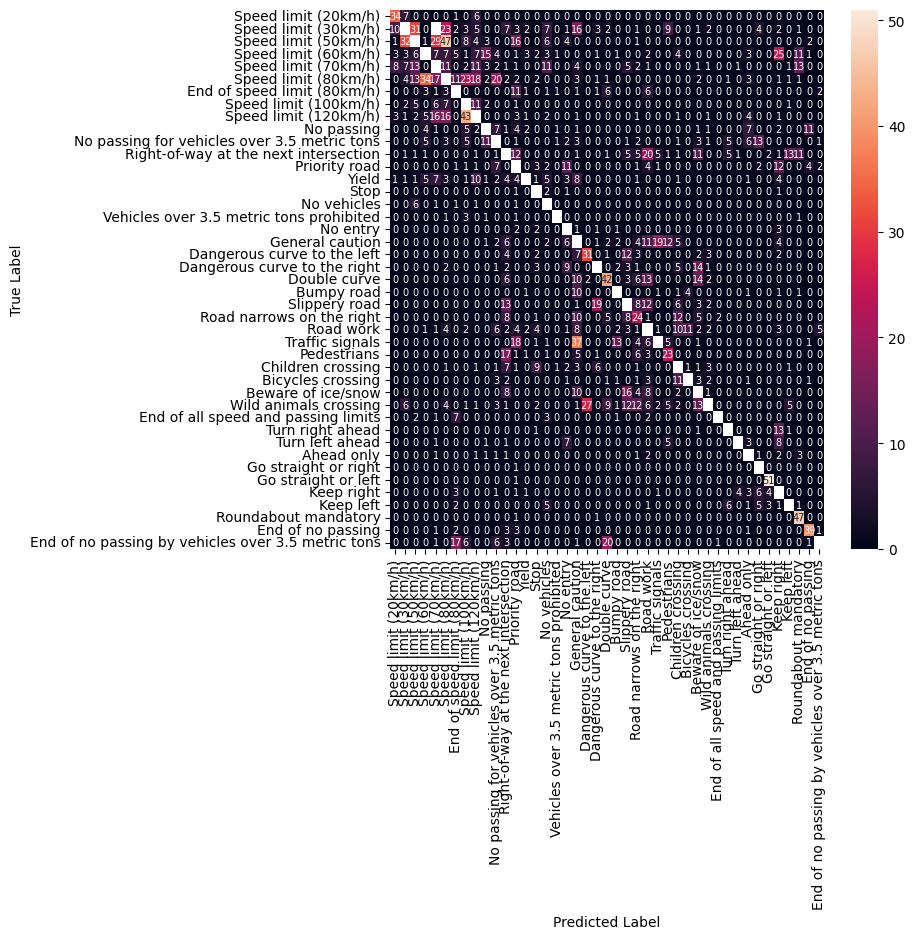

In [30]:
#Extract the model predictions on the test set (for confusion matrix building):
tf.random.set_seed(42)
np.random.seed(42)

pred = model.predict(X_test)
#pred

#Convert label matrices to index values for confustion matrix:
y_preds = []
for i in range(len(pred)):
  y_preds.append(np.argmax(pred[i]))
#y_preds

y_act = []
for i in range(len(y_test)):
  y_act.append(np.argmax(y_test[i]))
#y_act

#import torch
y_act =torch.Tensor(y_act)
y_preds = torch.Tensor(y_preds)

#Plot heatmap of classification results (masking values >50 to point out misclassifications)
fig, ax = plt.subplots(figsize=(7,7))
corr = confusion_matrix(y_preds, y_act)
names = signnames.values()
#corr/np.sum(corr), fmt='.1%'
sns.heatmap(corr, annot=True,
            xticklabels=names,yticklabels=names, fmt='d',annot_kws={"size": 7},
            mask= corr >51)#,
            #cmap="Blues")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [31]:
#

In [18]:
#Improved LeNet-5 
tf.random.set_seed(42)
np.random.seed(42)
eps = 10

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', padding='valid', input_shape=X_train.shape[1:]))
#model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', padding='valid'))
model.add(AveragePooling2D(pool_size=(2,2),strides=2,padding='valid',data_format=None,)) #is this right?
model.add(Dropout(rate=0.25)) 
model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu', padding='valid'))
model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu', padding='valid'))
model.add(AveragePooling2D(pool_size=(2,2),strides=2,padding='valid',data_format=None,)) #is this right?
model.add(Dropout(rate=0.25)) 
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dropout(rate=0.25)) 
model.add(Dense(84, activation='relu'))
model.add(Dense(43, activation='softmax'))

#Compile the model:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fit the model:
history3 = model.fit(X_train, y_train, batch_size=32, epochs=eps, validation_data=(X_val, y_val))


Epoch 1/10
1088/1088 [==============================] - 10s 7ms/step - loss: 1.5265 - accuracy: 0.5557 - val_loss: 0.3953 - val_accuracy: 0.8846
Epoch 2/10
1088/1088 [==============================] - 6s 5ms/step - loss: 0.3471 - accuracy: 0.8915 - val_loss: 0.1728 - val_accuracy: 0.9481
Epoch 3/10
1088/1088 [==============================] - 7s 6ms/step - loss: 0.2078 - accuracy: 0.9343 - val_loss: 0.1521 - val_accuracy: 0.9542
Epoch 4/10
1088/1088 [==============================] - 6s 5ms/step - loss: 0.1509 - accuracy: 0.9528 - val_loss: 0.1587 - val_accuracy: 0.9528
Epoch 5/10
1088/1088 [==============================] - 7s 6ms/step - loss: 0.1199 - accuracy: 0.9633 - val_loss: 0.1452 - val_accuracy: 0.9580
Epoch 6/10
1088/1088 [==============================] - 6s 5ms/step - loss: 0.0999 - accuracy: 0.9690 - val_loss: 0.0837 - val_accuracy: 0.9744
Epoch 7/10
1088/1088 [==============================] - 6s 6ms/step - loss: 0.0905 - accuracy: 0.9726 - val_loss: 0.0751 - val_accuracy

       loss  accuracy  val_loss  val_accuracy
0  1.526530  0.555677  0.395341      0.884580
1  0.347104  0.891462  0.172776      0.948073
2  0.207785  0.934280  0.152120      0.954195
3  0.150886  0.952786  0.158658      0.952834
4  0.119948  0.963332  0.145249      0.958050


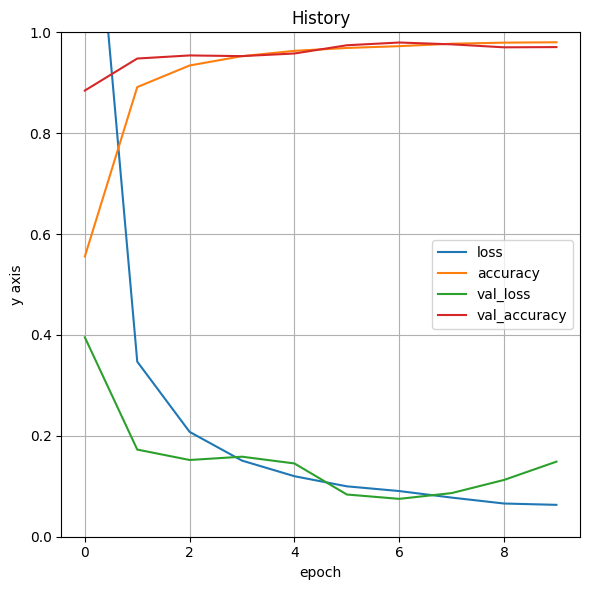

In [19]:
#Plot the loss and accuracy v. Epoch
df=pd.DataFrame(history3.history)
print(df.head())

fig,ax=plt.subplots(figsize=(6,6))
ax.plot(df['loss'], label='loss')
ax.plot(df['accuracy'], label='accuracy')
ax.plot(df['val_loss'], label='val_loss')
ax.plot(df['val_accuracy'], label='val_accuracy')
ax.legend(loc=0)
ax.set_title('History')
ax.set_xlabel('epoch')
ax.set_ylabel('y axis')
ax.set_ylim(0,1)
ax.grid()
plt.tight_layout()
plt.show()

395/395 [==============================] - 1s 2ms/step


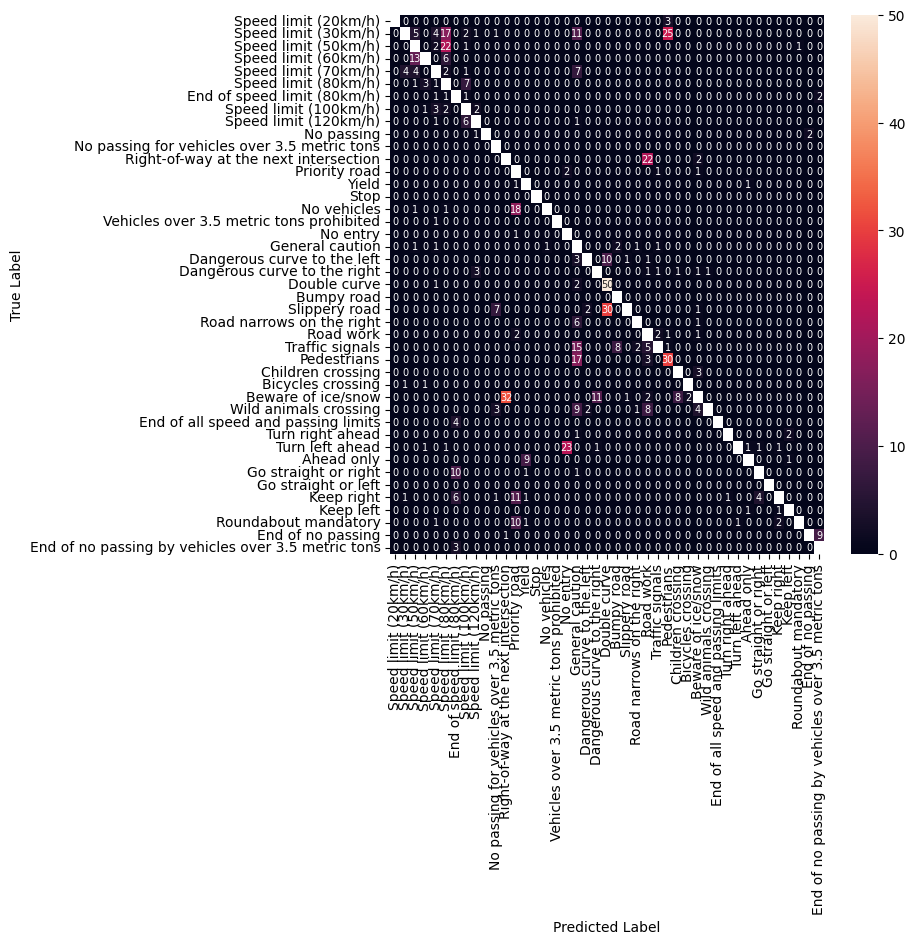

In [20]:
#Extract the model predictions on the test set (for confusion matrix building):
tf.random.set_seed(42)
np.random.seed(42)

pred = model.predict(X_test)
#pred

#Convert label matrices to index values for confustion matrix:
y_preds = []
for i in range(len(pred)):
  y_preds.append(np.argmax(pred[i]))
#y_preds

y_act = []
for i in range(len(y_test)):
  y_act.append(np.argmax(y_test[i]))
#y_act

#import torch
y_act =torch.Tensor(y_act)
y_preds = torch.Tensor(y_preds)

#Plot heatmap of classification results (masking values >50 to point out misclassifications)
fig, ax = plt.subplots(figsize=(7,7))
corr = confusion_matrix(y_preds, y_act)
names = signnames.values()
#corr/np.sum(corr), fmt='.1%'
sns.heatmap(corr, annot=True,
            xticklabels=names,yticklabels=names, fmt='d',annot_kws={"size": 7},
            mask= corr >51)#,
            #cmap="Blues")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()